In [6]:
import pandas as pd

paths = {
	"binance": "/Users/ilyat/Documents/quant📈/ccxt_data/data/binance/ohlc/perps/combined_enriched.csv",
	"bybit": "/Users/ilyat/Documents/quant📈/ccxt_data/data/bybit/ohlc/perps/combined_enriched.csv",
	"hyperliquid": "/Users/ilyat/Documents/quant📈/ccxt_data/data/hyperliquid/ohlc/perps/combined_enriched.csv",
	"paradex": "/Users/ilyat/Documents/quant📈/ccxt_data/data/paradex/ohlc/perps/combined.csv",
}

df = pd.read_csv(paths['binance'])

In [7]:
df.columns

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'market_cap', 'fundingRate', 'buy_volume_ratio', 'Buy_Trades',
       'Total_Trades'],
      dtype='object')

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_32586/2121106758.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = close.pct_change().dropna(how='all')


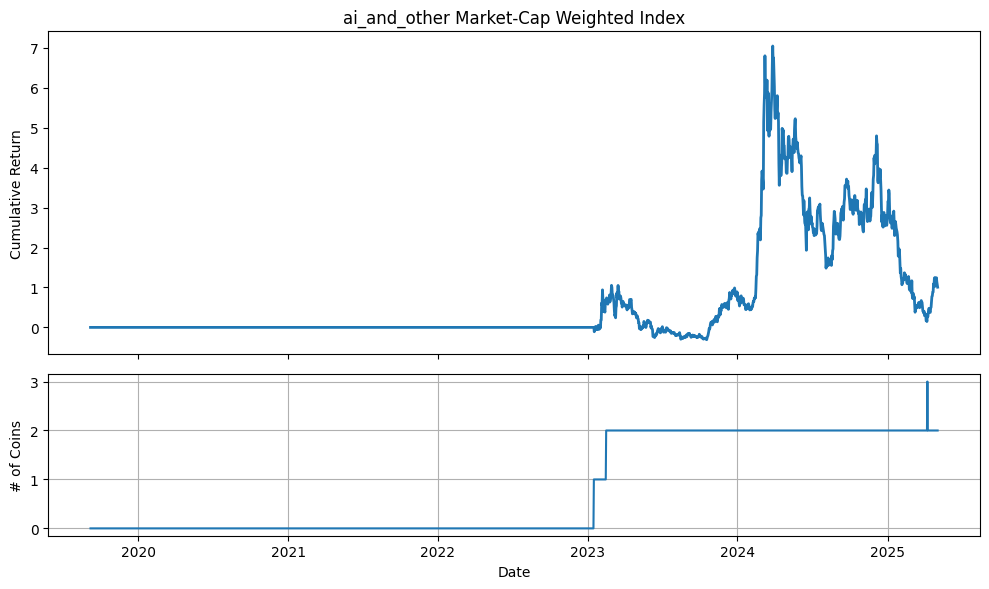

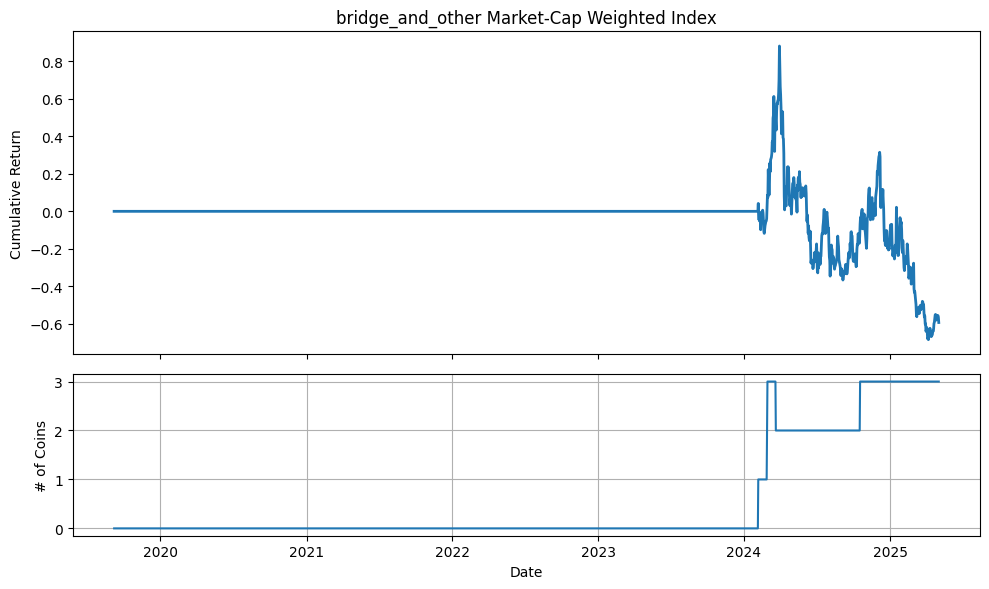

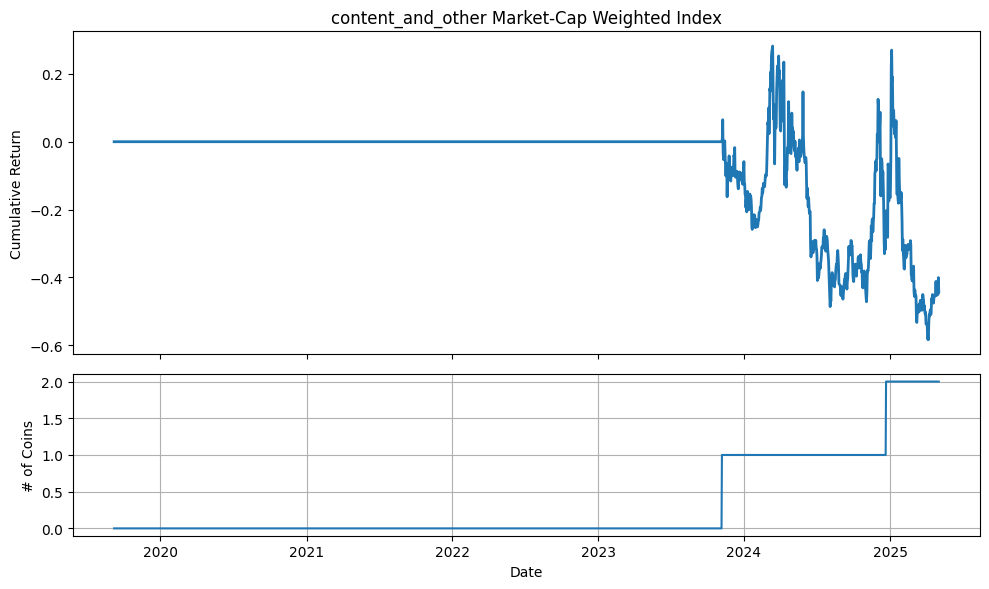

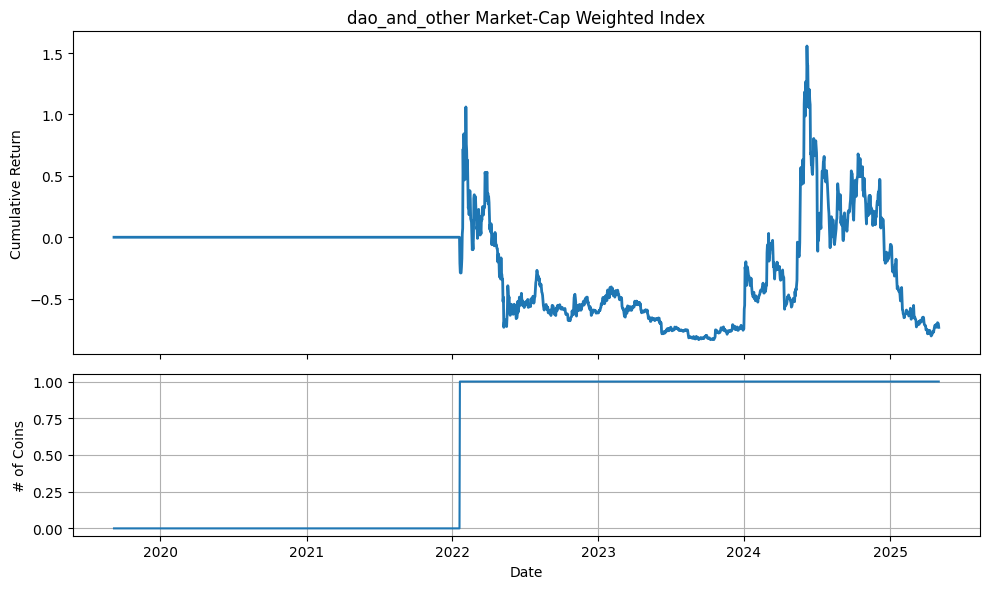

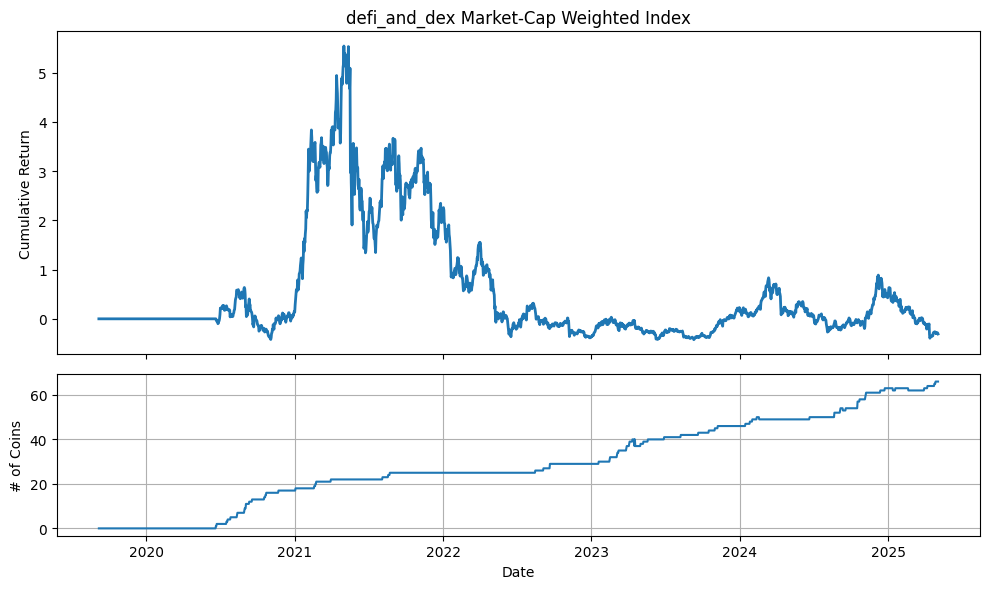

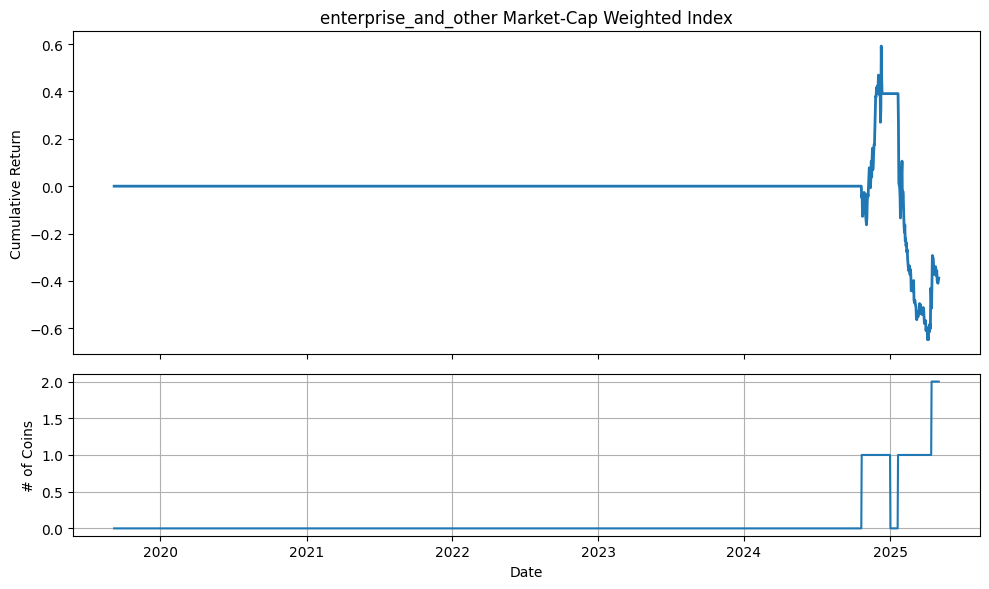

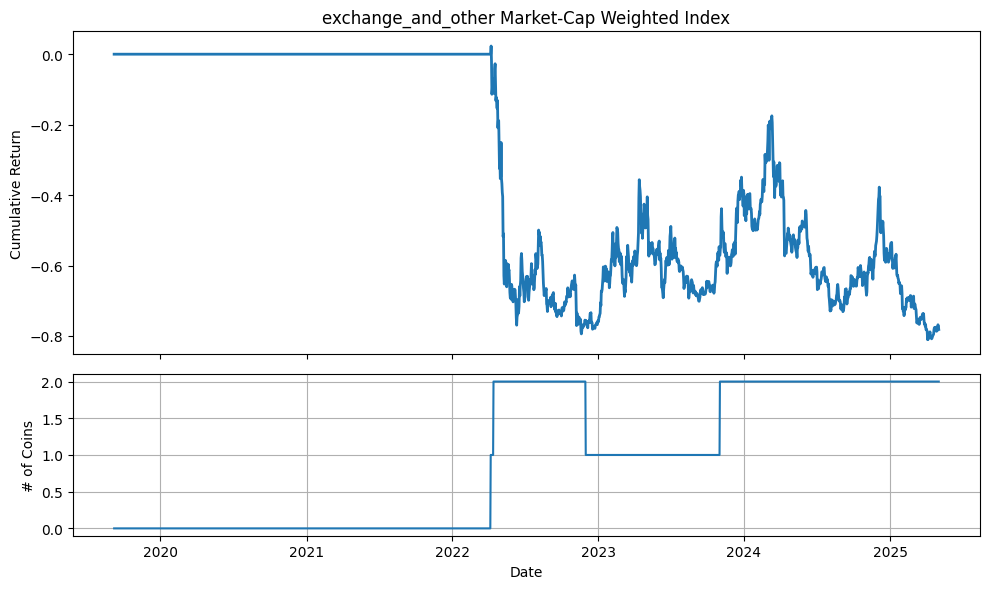

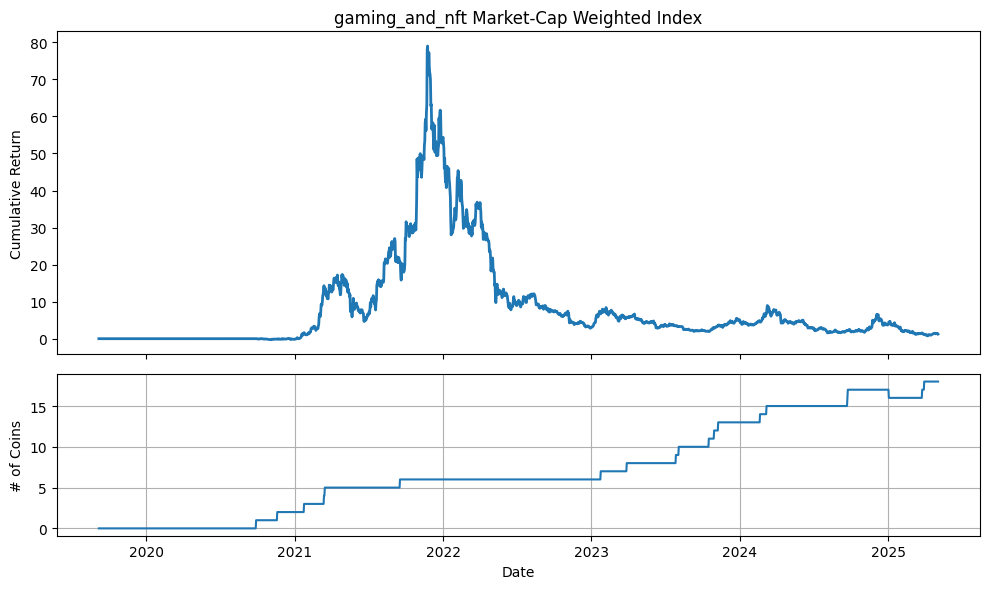

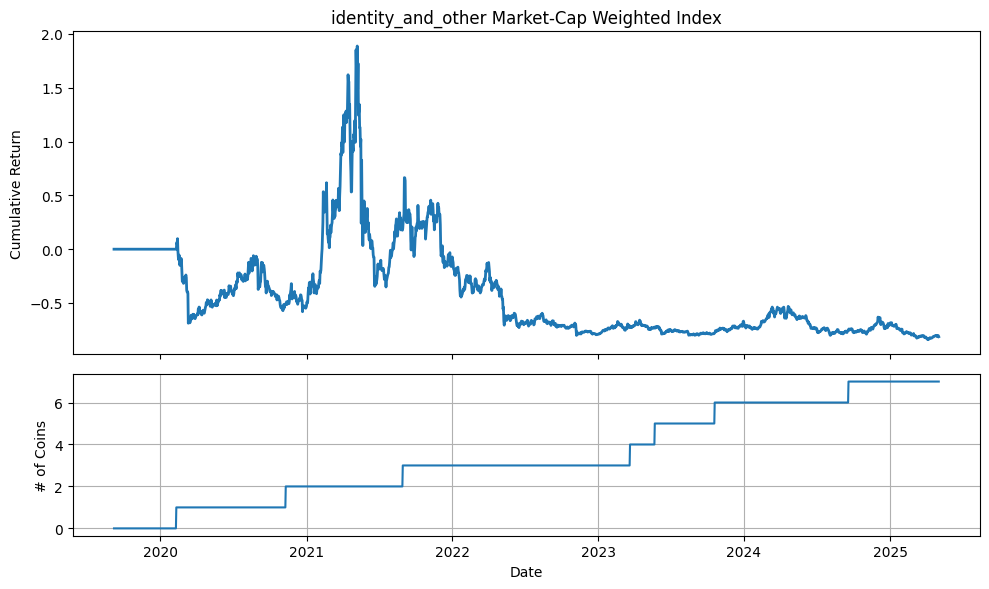

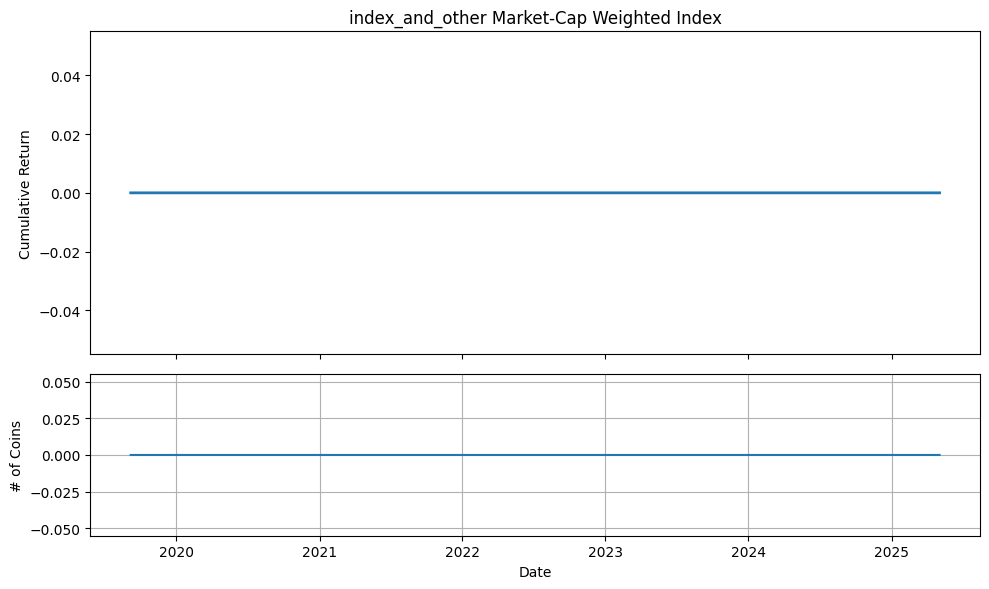

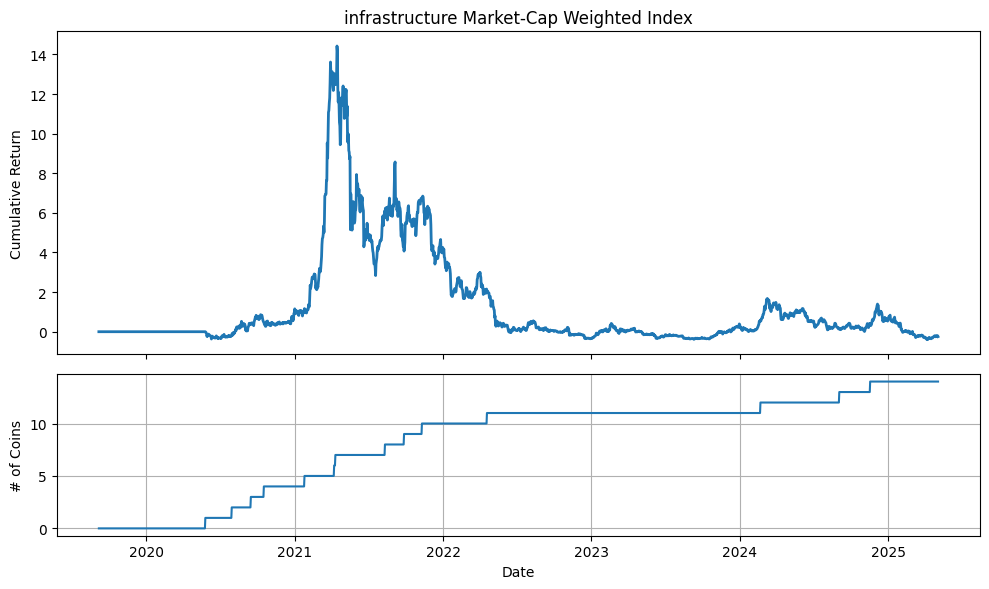

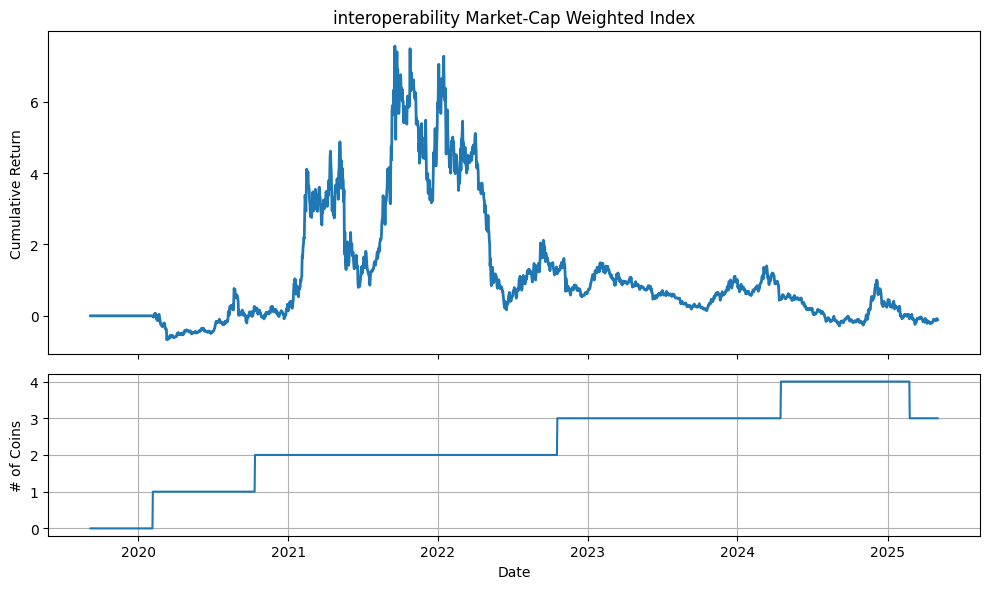

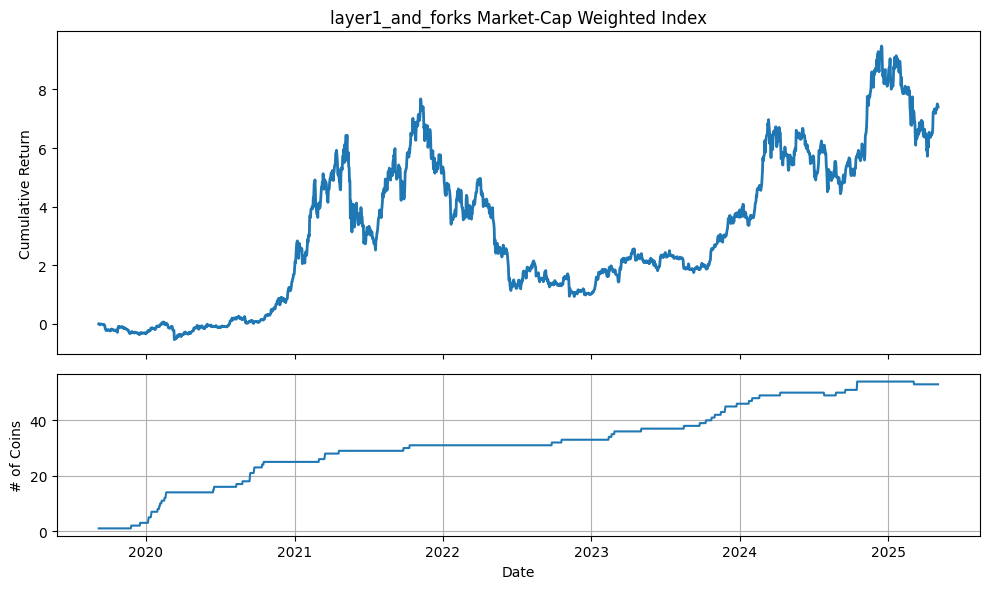

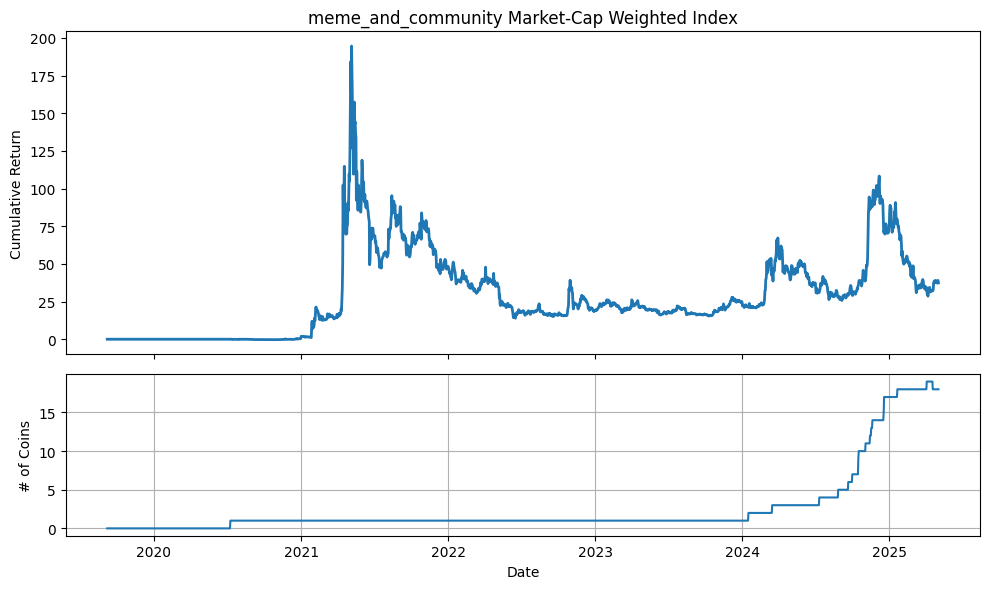

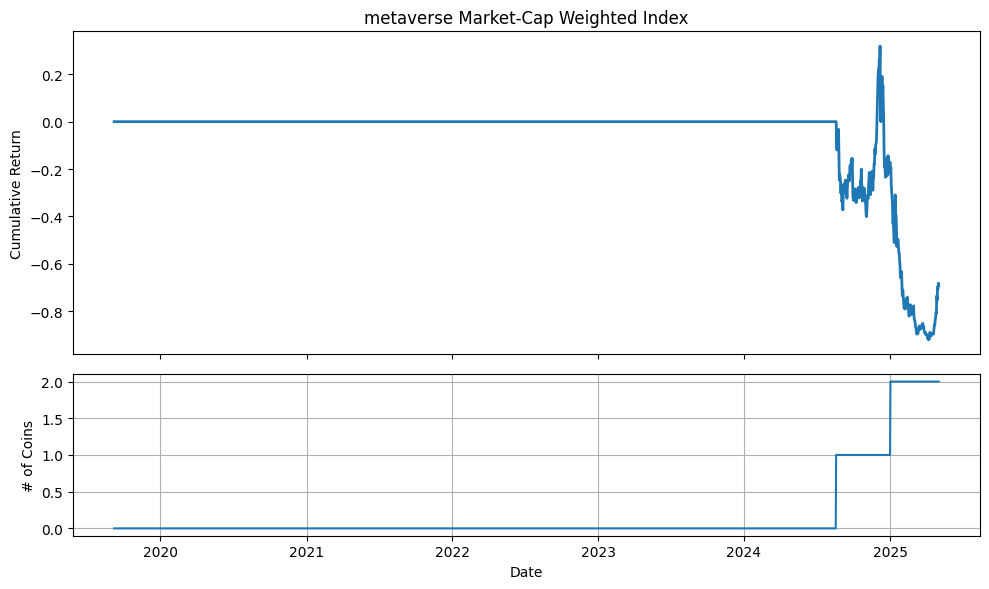

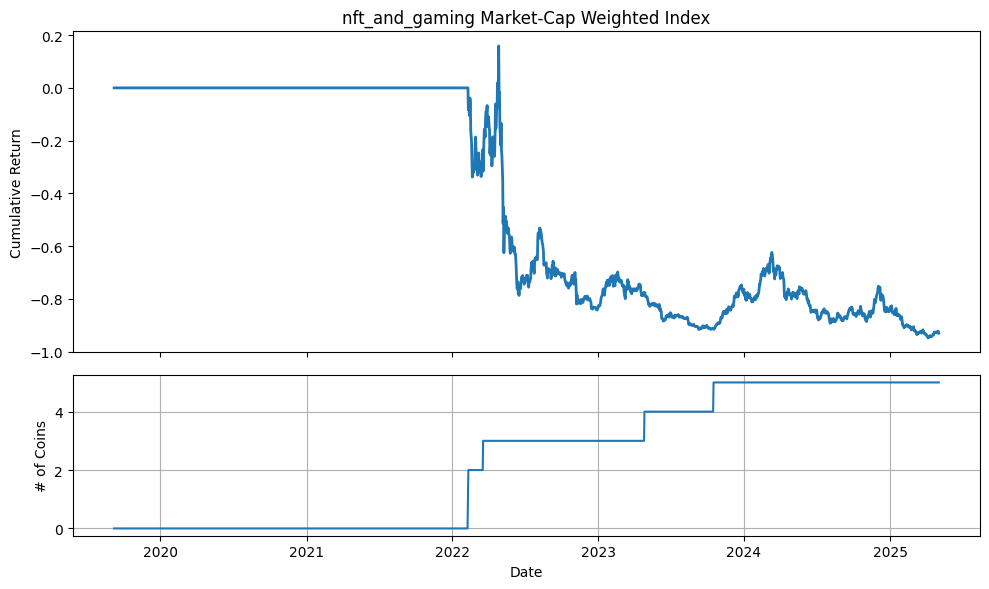

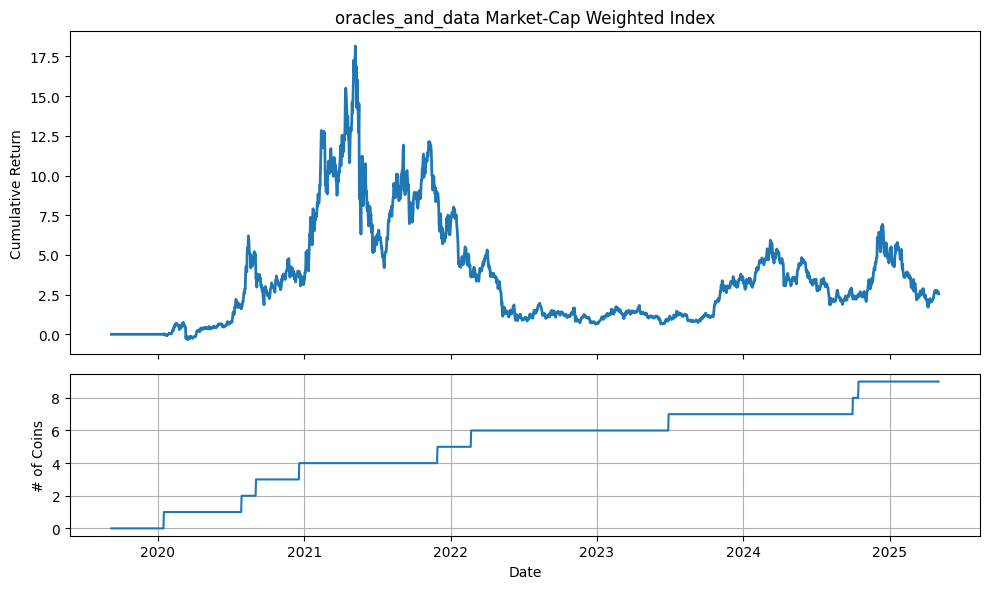

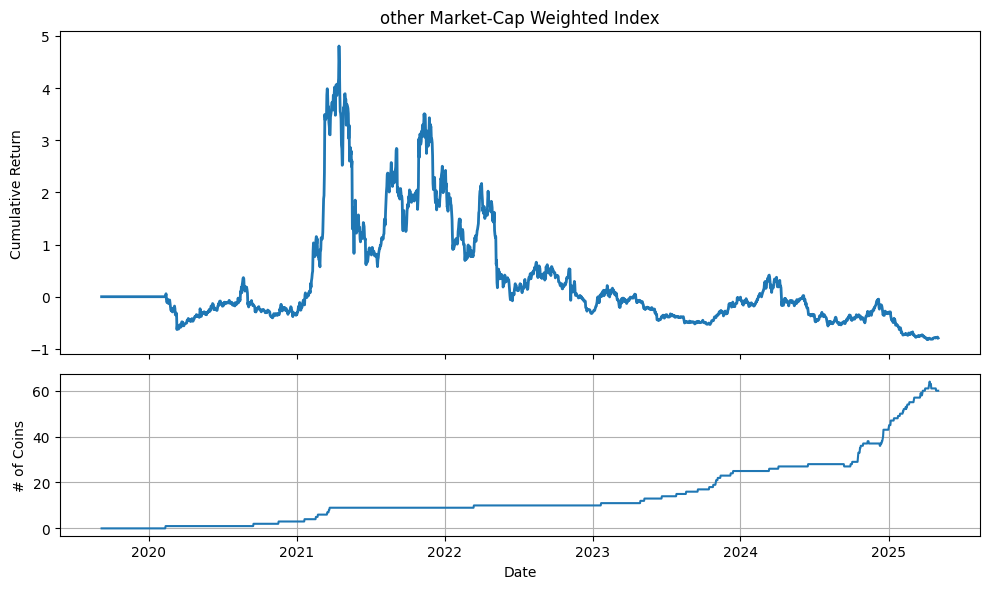

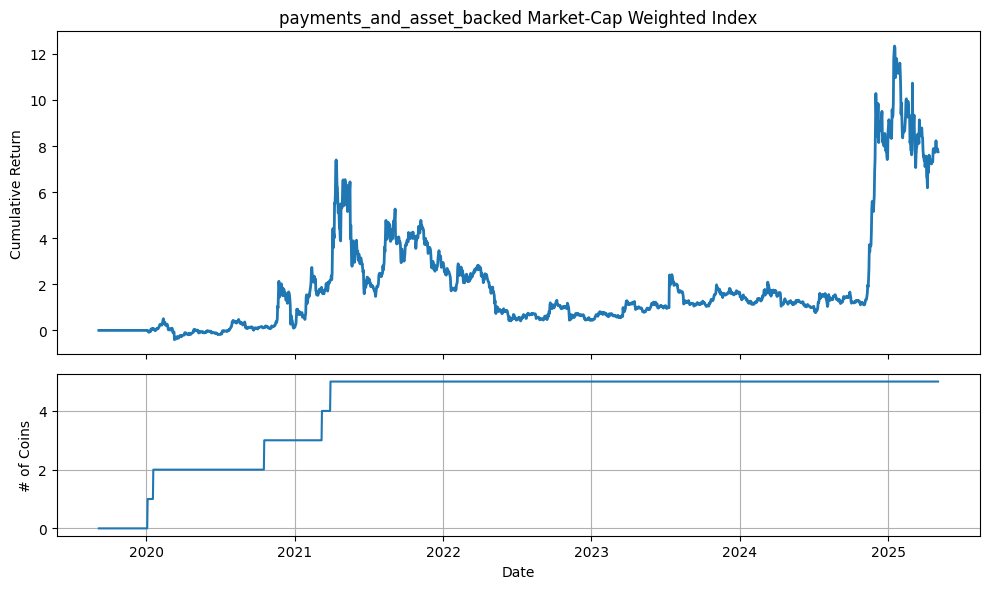

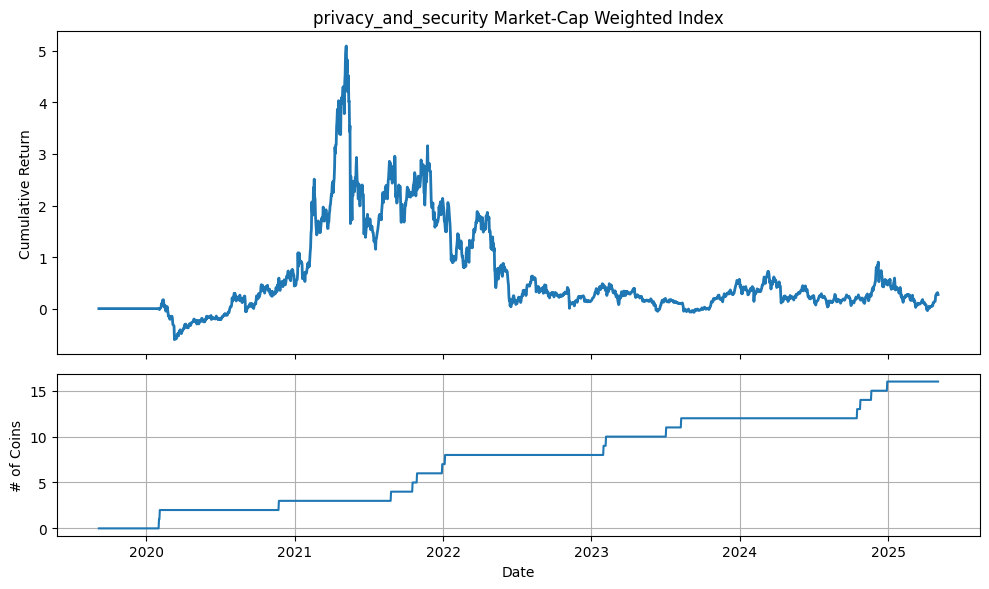

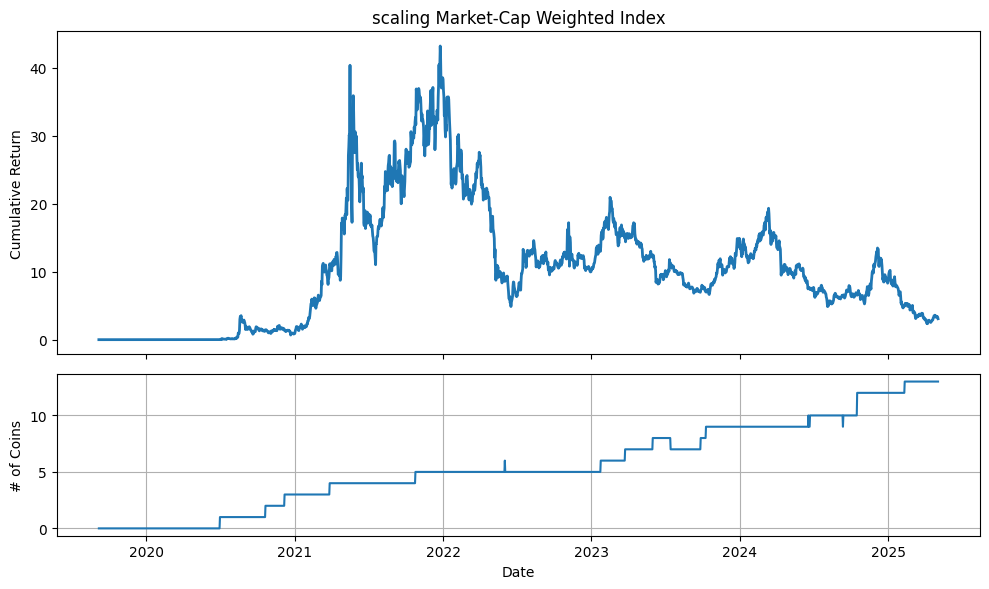

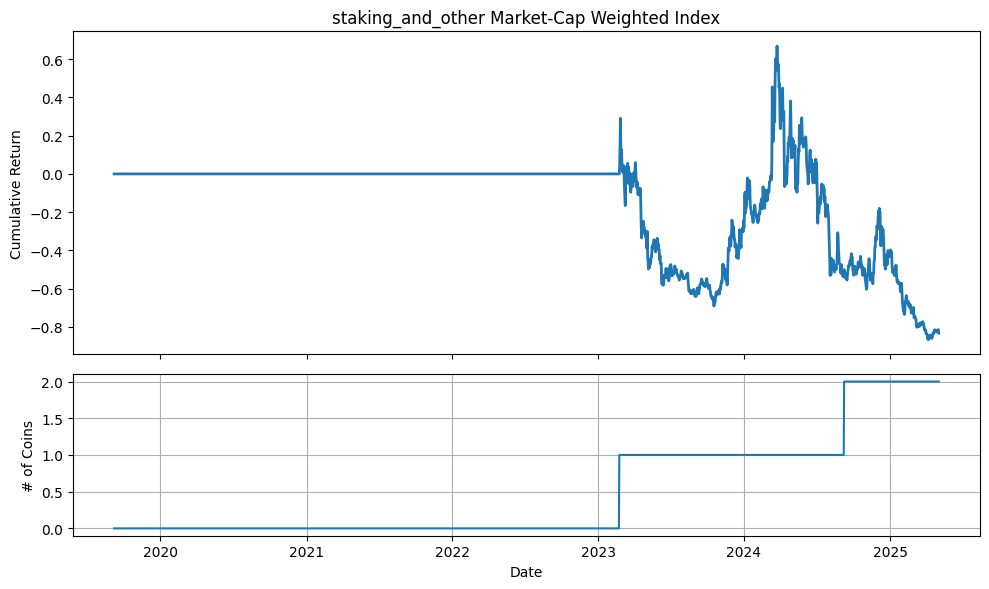

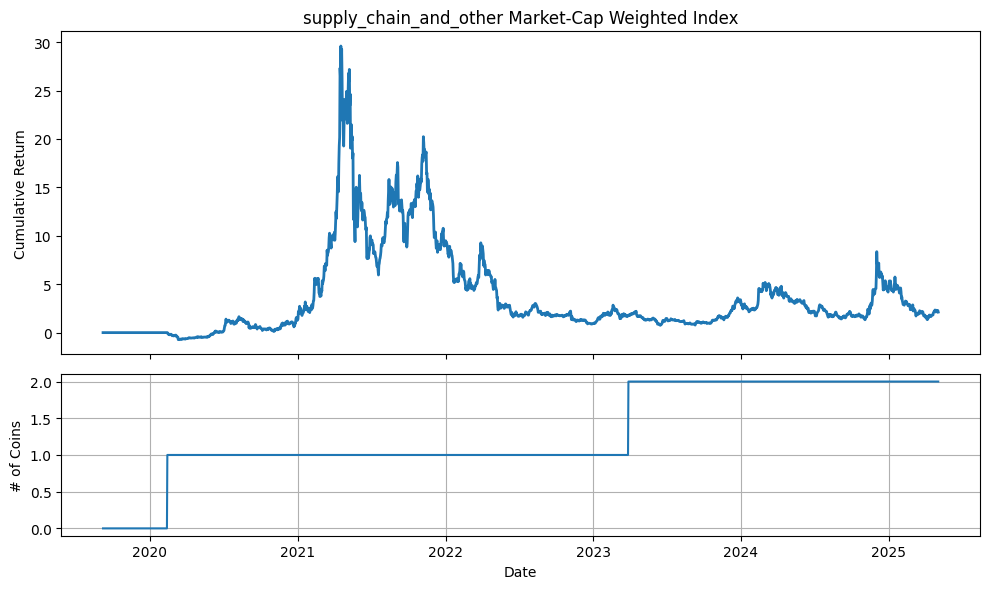

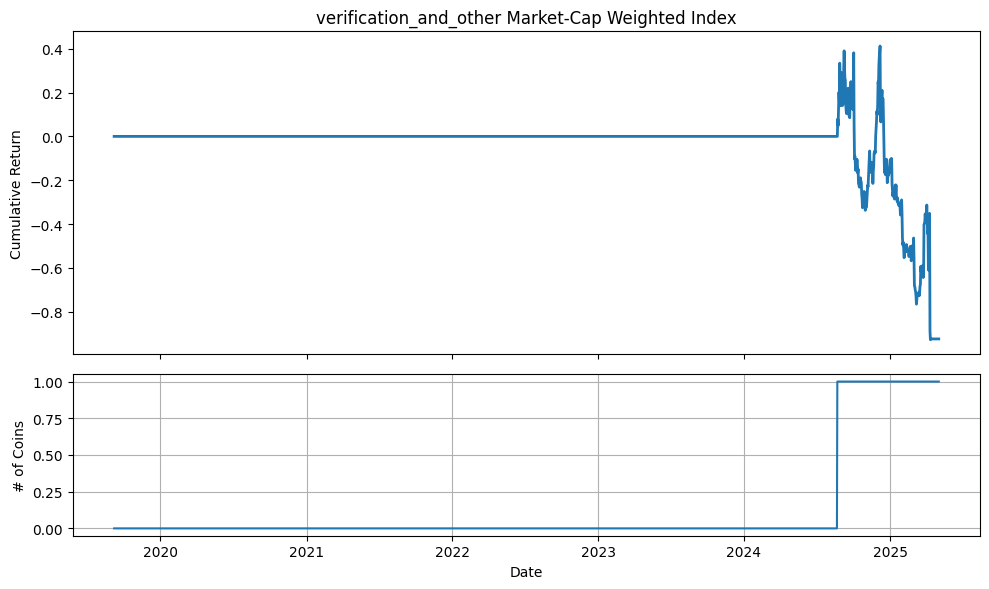

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load tags
tags = pd.read_csv('tags_2.csv')  # columns: coin,tag

# 2) Merge & prepare
df2 = (
    df
    .merge(tags, left_on='symbol', right_on='coin')
    .assign(timestamp=lambda x: pd.to_datetime(x['timestamp']))
    .sort_values('timestamp')
)

# 3) Pivot
close  = df2.pivot(index='timestamp', columns='symbol', values='close')
mktcap = df2.pivot(index='timestamp', columns='symbol', values='market_cap')

# 4) Returns
rets = close.pct_change().dropna(how='all')

for tag, grp in tags.groupby('tag')['coin']:
    coins = [c for c in grp if c in rets.columns]
    if not coins:
        continue

    sub_rets   = rets[coins]
    sub_mktcap = mktcap[coins].ffill(limit=20).fillna(0)

    # 5) weights & tag returns
    w = sub_mktcap.div(sub_mktcap.sum(axis=1), axis=0)
    w = w.div(w.sum(axis=1), axis=0).fillna(0)

    tag_ret = (w * sub_rets).sum(axis=1)
    cum_ret = (1 + tag_ret).cumprod() - 1

    # 6) coin‐count series
    coin_count = (w > 0).sum(axis=1)

    # 7) Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6),
                                   gridspec_kw={'height_ratios':[2,1]},
                                   sharex=True)

    ax1.plot(cum_ret.index, cum_ret, lw=2)
    ax1.set_title(f'{tag} Market‑Cap Weighted Index')
    ax1.set_ylabel('Cumulative Return')

    ax2.plot(coin_count.index, coin_count.values, lw=1.5)
    ax2.set_ylabel('# of Coins')
    ax2.set_xlabel('Date')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
